## Checking linear regression assumptions for Gin as a predictor of AP biomarkers

It's easy to throw a linear regression line on top of a plot along with R^2 and a p-value. But are the linear regression assumptions met?! My goal here is to identify the AP biomarkers that are valid linear dependent variables.

I'm open to disagreement with my interpretation. I don't do this sort of analysis often (or ever), so I could be off the mark.

In [3]:
%matplotlib inline
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from seaborn import histplot, regplot, pointplot, swarmplot
from scipy import stats

from utility import get_apd90, get_cl, get_dvdt

plt.style.use('seaborn-whitegrid')

### Load in the variables

The DataFrame has the following columns:
- `cell` (text): the cell name
- `is_spont` (bool): `True` if spontaneous and `False` if not
- `gins` (float): 1/Rin, measured in nS
- `gins_cm` (float): 1/Rin/Cm measures in pF/nS
- `cm` (float) – cell capacitance
- `mdp` (float) – maximum diastolic potential
- `apd` – action potential duration at 90% repolarization
- `cl` – cycle length
- `dVdt` – maximum upstroke velocity

In [13]:
all_cells = listdir('./data/cells')

all_cell_params = {'cell': [],
               'is_spont': [],
               'gins': [],
               'gins_cm': [],
               'cm': [],
               'mdp': [],
               'apd': [],
               'cl': [],
               'dVdt': []}

# gin, cm, mdp, apd, cl, dVdt
for cell in all_cells:
    if 'DS_Store' in cell:
        continue
        
    ap_dat = pd.read_csv(f'./data/cells/{cell}/Pre-drug_spont.csv')
    cell_params = pd.read_excel(f'./data/cells/{cell}/cell-params.xlsx')
    
    gin = 1/cell_params['Rm'].values[0]*1000
    
    all_cell_params['cell'].append(cell)
    all_cell_params['gins'].append(gin)
    all_cell_params['cm'].append(cell_params['Cm'].values[0])
    all_cell_params['gins_cm'].append(gin / cell_params['Cm'].values[0]*1E6)
    
    all_cell_params['mdp'].append( ap_dat['Voltage (V)'].min()*1000)
    
    
    if not (((ap_dat['Voltage (V)'].max() - ap_dat['Voltage (V)'].min()) > .03)
                and (ap_dat['Voltage (V)'].max() > .01)):
        all_cell_params['is_spont'].append(False)
        all_cell_params['apd'].append(None)
        all_cell_params['cl'].append(None)
        all_cell_params['dVdt'].append(None)
        continue
        
    all_cell_params['is_spont'].append(True)
    all_cell_params['apd'].append(get_apd90(ap_dat))
    all_cell_params['cl'].append(get_cl(ap_dat))
    all_cell_params['dVdt'].append(get_dvdt(ap_dat))

all_cell_params = pd.DataFrame(all_cell_params)

all_cell_params;
print(f'This dataset includes {len(all_cell_params)} cells')

This dataset includes 39 cells


### Assumption 1: Appearance of linear relationship

I would say there's a bit of a linear appearance for gins and MDP, APD, and dV/dt. I attempted a couple of nonlinear transformations (log10, sqrt) of `gins` to improve the apparent linearity, but they don't look great.

I'm going to say the three relationships meet this assumption.

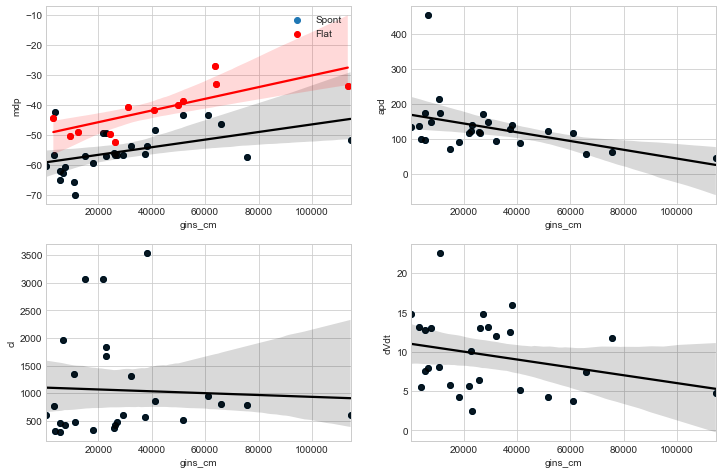

In [15]:
fig, axs = plt.subplots(2,2, figsize=(12, 8));
axs = axs.flatten()

dependents = ['mdp', 'apd', 'cl', 'dVdt']
for i, ylabel in enumerate(dependents):
    if i == 0:
        axs[i].scatter(x=all_cell_params[all_cell_params['is_spont']]['gins_cm'], y=all_cell_params[all_cell_params['is_spont']][ylabel], label='Spont')
        regplot(x=all_cell_params[all_cell_params['is_spont']]['gins_cm'], y=all_cell_params[all_cell_params['is_spont']][ylabel], color='k', ax=axs[i])
        
        axs[i].scatter(x=all_cell_params[~all_cell_params['is_spont']]['gins_cm'], y=all_cell_params[~all_cell_params['is_spont']][ylabel], color='r', label='Flat')
        regplot(x=all_cell_params[~all_cell_params['is_spont']]['gins_cm'], y=all_cell_params[~all_cell_params['is_spont']][ylabel], color='r', ax=axs[i])
        axs[i].legend()
    else:
        axs[i].scatter(x=all_cell_params['gins_cm'], y=all_cell_params[ylabel])
        curr_dat = all_cell_params
        regplot(x=curr_dat['gins_cm'], y=curr_dat[ylabel], color='k', ax=axs[i])

### Assumption 2: Normality of the residuals
Figures below. Checking residual normality. See here: https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html

Ideally, you want something falling on the red line. Some deviations at the edges is normal. I'm going to go ahead and say MDP looks quite good. The others don't look so good.

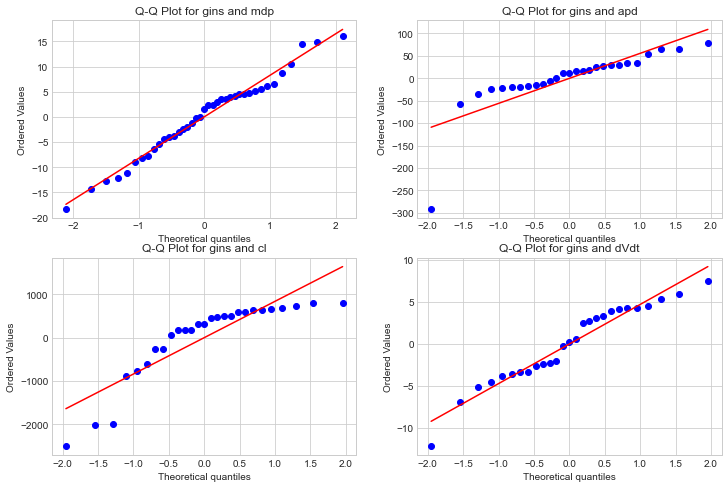

In [17]:
fig, axs = plt.subplots(2,2, figsize=(12, 8));
axs = axs.flatten()

for i, ylabel in enumerate(dependents):
    selected_rows = all_cell_params[~all_cell_params[ylabel].isnull()]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(selected_rows['gins_cm'], selected_rows[ylabel])
    predictions = slope * selected_rows['gins_cm'] + intercept
    residuals = predictions - selected_rows[ylabel]

    stats.probplot(residuals, dist="norm", plot=axs[i])
    axs[i].set_title(f"Q-Q Plot for gins and {ylabel}")

plt.show()

### Assumption 3: no multicolinearity among the predictors

Only using Gins and Cm as predictors in this study. No colinearity found (p<.05).

<AxesSubplot:xlabel='gins', ylabel='cm'>

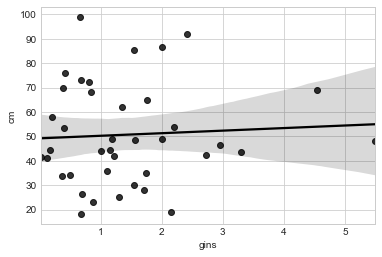

In [18]:
fig, ax = plt.subplots(1,1, figsize=(6, 4));

regplot(x=all_cell_params['gins'], y=all_cell_params['cm'], color='k', ax=ax)

### Assumption 4: No Autocorrelation
Not relevant here, as each record is independent.

### Assumption 5:  Homoscedasticity (e.g., same variance in error terms)

It's important that the variance is constant across all sampled ranges. MDP looks quite consistent.

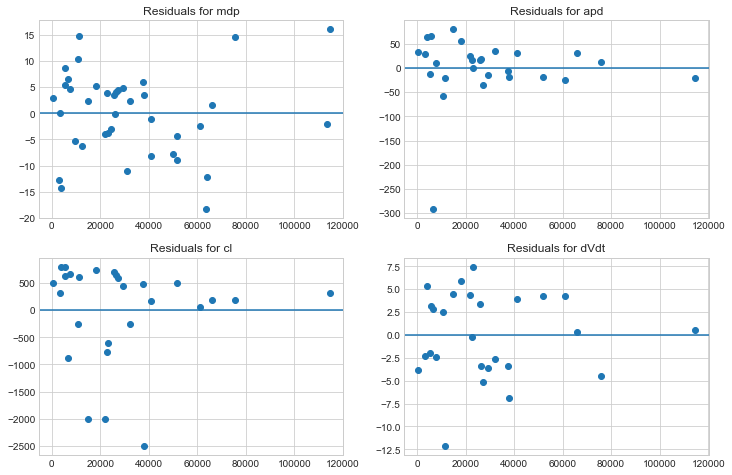

In [21]:
fig, axs = plt.subplots(2,2, figsize=(12, 8));
axs = axs.flatten()

for i, ylabel in enumerate(dependents):
    selected_rows = all_cell_params[~all_cell_params[ylabel].isnull()]
        
    slope, intercept, r_value, p_value, std_err = stats.linregress(selected_rows['gins_cm'], selected_rows[ylabel])
    predictions = slope * selected_rows['gins_cm'] + intercept
    residuals = predictions - selected_rows[ylabel]

    axs[i].scatter(selected_rows['gins_cm'], residuals)
    axs[i].axhline(0)
    
    axs[i].set_title(f"Residuals for {ylabel}")

plt.show()

### Conclusions
- The assumptions of linear regression are met for Gin/Cm and MDP, but not the other biomarkers.